In [18]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from graphviz import Digraph
from IPython.display import display

In [19]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, criterion="gini", max_depth=None, min_impurity_decrease=0.0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
        
    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)
        return self  

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape

        if len(y) == 0:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        if len(set(y)) == 1:
            return TreeNode(value=y[0])

        if self.max_depth and depth >= self.max_depth:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold, best_gain = None, None, -np.inf
        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature], threshold)
                if gain > best_gain:
                    best_feature, best_threshold, best_gain = feature, threshold, gain

        if best_feature is None or best_gain < self.min_impurity_decrease:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return TreeNode(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)


    def _impurity(self, y):
        if self.criterion == "gini":
            probs = np.bincount(y) / len(y)
            return 1 - np.sum(probs ** 2)
        elif self.criterion == "entropy":
            probs = np.bincount(y) / len(y)
            return -np.sum([p * np.log2(p) for p in probs if p > 0])
        elif self.criterion == "misclassification":
            return 1 - max(np.bincount(y) / len(y))
        else:
            raise ValueError("Invalid criterion")

    def _information_gain(self, y, X_column, threshold):
        parent_impurity = self._impurity(y)
        left_mask = X_column <= threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0
        left_impurity = self._impurity(y[left_mask])
        right_impurity = self._impurity(y[right_mask])
        child_impurity = (np.sum(left_mask) * left_impurity + np.sum(right_mask) * right_impurity) / len(y)
        return parent_impurity - child_impurity
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def get_params(self, deep=True):
        return {"criterion": self.criterion, "max_depth": self.max_depth, "min_impurity_decrease": self.min_impurity_decrease}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    

In [20]:
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10, max_depth=None, min_impurity_decrease=0.0):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.trees = [DecisionTree(max_depth=max_depth, min_impurity_decrease=min_impurity_decrease) for _ in range(n_trees)]
        self.classes_ = None  

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for tree in self.trees:
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            tree.fit(X_sample, y_sample)
        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

    def get_params(self, deep=True):
        return {"n_trees": self.n_trees, "max_depth": self.max_depth, "min_impurity_decrease": self.min_impurity_decrease}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [21]:
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
           "gill-attachment", "gill-spacing", "gill-size", "gill-color",
           "stalk-shape", "stalk-root", "stalk-surface-above-ring",
           "stalk-surface-below-ring", "stalk-color-above-ring",
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
           "ring-type", "spore-print-color", "population", "habitat"]
    df = pd.read_csv(url, names=columns)
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.drop(columns=['class']).values
    y = (df['class'] == 'p').astype(int).values 
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_data()

trees = {
    "Gini": DecisionTree(criterion="gini", max_depth=5),
    "Entropy": DecisionTree(criterion="entropy", max_depth=5),
    "Misclassification": DecisionTree(criterion="misclassification", max_depth=5)
}

In [3]:
def zero_one_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)


def compute_accuracy(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_acc = np.mean(train_preds == y_train)
    test_acc = np.mean(test_preds == y_test)
    overfitting_gap = train_acc - test_acc  
    
    train_loss = zero_one_loss(y_train, train_preds)
    test_loss = zero_one_loss(y_test, test_preds)
    
    return train_acc, test_acc, overfitting_gap, train_loss, test_loss

# Check overfitting for Decision Trees
print("\nChecking Overfitting:\n")
for name, tree in trees.items():
    train_acc, test_acc, gap, train_loss, test_loss = compute_accuracy(tree, X_train, y_train, X_test, y_test)
    print(f"{name} Tree - Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Overfitting Gap: {gap:.4f}, Training 0-1 Loss: {train_loss:.4f}, Test 0-1 Loss: {test_loss:.4f}")

# Check overfitting for Random Forest
rf_train_acc, rf_test_acc, rf_gap, rf_train_loss, rf_test_loss = compute_accuracy(rf, X_train, y_train, X_test, y_test)
print(f"Random Forest - Training Accuracy: {rf_train_acc:.4f}, Test Accuracy: {rf_test_acc:.4f}, Overfitting Gap: {rf_gap:.4f}, Training 0-1 Loss: {rf_train_loss:.4f}, Test 0-1 Loss: {rf_test_loss:.4f}")



Checking Overfitting:

Gini Tree - Training Accuracy: 0.9778, Test Accuracy: 0.9852, Overfitting Gap: -0.0074, Training 0-1 Loss: 0.0222, Test 0-1 Loss: 0.0148
Entropy Tree - Training Accuracy: 0.9795, Test Accuracy: 0.9735, Overfitting Gap: 0.0060, Training 0-1 Loss: 0.0205, Test 0-1 Loss: 0.0265
Misclassification Tree - Training Accuracy: 0.9723, Test Accuracy: 0.9705, Overfitting Gap: 0.0018, Training 0-1 Loss: 0.0277, Test 0-1 Loss: 0.0295
Random Forest - Training Accuracy: 0.9794, Test Accuracy: 0.9889, Overfitting Gap: -0.0095, Training 0-1 Loss: 0.0206, Test 0-1 Loss: 0.0111


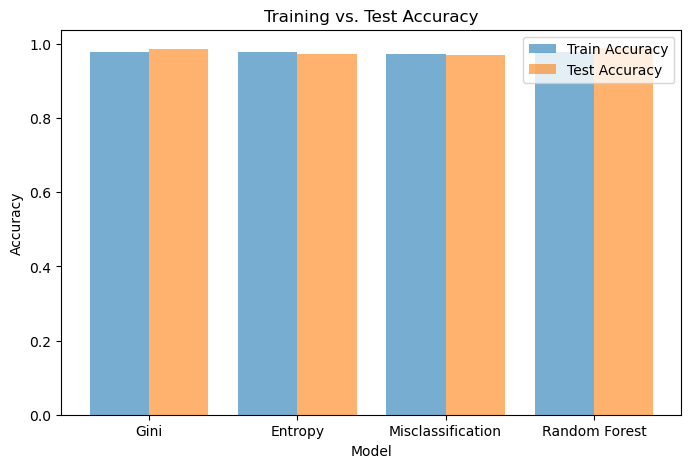

In [4]:
model_names = ["Gini", "Entropy", "Misclassification", "Random Forest"]
train_accuracies = [compute_accuracy(trees[name], X_train, y_train, X_test, y_test)[0] for name in model_names if name in trees]
test_accuracies = [compute_accuracy(trees[name], X_train, y_train, X_test, y_test)[1] for name in model_names if name in trees]

rf_train_acc, rf_test_acc, _, _, _ = compute_accuracy(rf, X_train, y_train, X_test, y_test)
train_accuracies.append(rf_train_acc)
test_accuracies.append(rf_test_acc)

plt.figure(figsize=(8, 5))
bar_width = 0.4
x = range(len(model_names))

plt.bar(x, train_accuracies, width=bar_width, alpha=0.6, label="Train Accuracy")
plt.bar([p + bar_width for p in x], test_accuracies, width=bar_width, alpha=0.6, label="Test Accuracy")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy")
plt.xticks([p + bar_width / 2 for p in x], model_names)
plt.legend()
plt.show()


In [5]:
class RandomForestV2:
    def __init__(self, n_trees=10, max_depth=None, min_impurity_decrease=0.0, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.trees = [DecisionTree(max_depth=max_depth, min_impurity_decrease=min_impurity_decrease) for _ in range(n_trees)]
    
    def fit(self, X, y):
        num_features = X.shape[1]
        for tree in self.trees:
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]

            if self.max_features:
                feature_indices = np.random.choice(num_features, self.max_features, replace=False)
                tree.feature_indices = feature_indices
                X_sample = X_sample[:, feature_indices]

            tree.fit(X_sample, y_sample)

    def predict(self, X):
        predictions = []
        for tree in self.trees:
            if hasattr(tree, "feature_indices"):
                X_subset = X[:, tree.feature_indices]
                predictions.append(tree.predict(X_subset))
            else:
                predictions.append(tree.predict(X))

        predictions = np.array(predictions)
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

def evaluate_random_forest_versions():
    rf_versions = {
        "Original RF": RandomForest(n_trees=10, max_depth=5),
        "Deeper RF": RandomForest(n_trees=10, max_depth=6),
        "Deeper RF 2": RandomForest(n_trees=10, max_depth=7),
        "Larger RF": RandomForest(n_trees=50, max_depth=5),  
        "Feature-Subset RF": RandomForestV2(n_trees=10, max_depth=5, max_features=5) 
    }

    print("\nComparing Random Forest Variants:\n")
    for name, model in rf_versions.items():
        model.fit(X_train, y_train)
        train_acc, test_acc, gap, train_loss, test_loss = compute_accuracy(model, X_train, y_train, X_test, y_test)
    
        print(f"{name} - Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Overfitting Gap: {gap:.4f}, Training 0-1 Loss: {train_loss:.4f}, Test 0-1 Loss: {test_loss:.4f}")

evaluate_random_forest_versions()



Comparing Random Forest Variants:

Original RF - Training Accuracy: 0.9826, Test Accuracy: 0.9883, Overfitting Gap: -0.0057, Training 0-1 Loss: 0.0174, Test 0-1 Loss: 0.0117
Deeper RF - Training Accuracy: 0.9958, Test Accuracy: 0.9969, Overfitting Gap: -0.0011, Training 0-1 Loss: 0.0042, Test 0-1 Loss: 0.0031
Deeper RF 2 - Training Accuracy: 1.0000, Test Accuracy: 1.0000, Overfitting Gap: 0.0000, Training 0-1 Loss: 0.0000, Test 0-1 Loss: 0.0000
Larger RF - Training Accuracy: 0.9902, Test Accuracy: 0.9951, Overfitting Gap: -0.0049, Training 0-1 Loss: 0.0098, Test 0-1 Loss: 0.0049
Feature-Subset RF - Training Accuracy: 0.9822, Test Accuracy: 0.9852, Overfitting Gap: -0.0031, Training 0-1 Loss: 0.0178, Test 0-1 Loss: 0.0148


In [6]:
# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train):
    param_grid = {
        "max_depth": [3, 5, 7, 10],
        "min_impurity_decrease": [0.0, 0.01, 0.02, 0.05]
    }

    grid_search = GridSearchCV(DecisionTree(), param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_grid_tree = grid_search.best_estimator_
    print(f"Best Grid Search Decision Tree: {grid_search.best_params_}, Accuracy: {grid_search.best_score_:.4f}")

    random_search = RandomizedSearchCV(DecisionTree(), param_grid, n_iter=5, cv=5, scoring="accuracy", random_state=42)
    random_search.fit(X_train, y_train)
    best_random_tree = random_search.best_estimator_
    print(f"Best Random Search Decision Tree: {random_search.best_params_}, Accuracy: {random_search.best_score_:.4f}")

    return best_grid_tree, best_random_tree

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train):
    param_grid = {
        "n_trees": [10, 20, 50, 100],
        "max_depth": [5, 7, 10, 15]
    }

    grid_search = GridSearchCV(RandomForest(), param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_grid_rf = grid_search.best_estimator_
    print(f"Best Grid Search Random Forest: {grid_search.best_params_}, Accuracy: {grid_search.best_score_:.4f}")

    random_search = RandomizedSearchCV(RandomForest(), param_grid, n_iter=5, cv=5, scoring="accuracy", random_state=42)
    random_search.fit(X_train, y_train)
    best_random_rf = random_search.best_estimator_
    print(f"Best Random Search Random Forest: {random_search.best_params_}, Accuracy: {random_search.best_score_:.4f}")

    return best_grid_rf, best_random_rf

print("\nTuning Decision Tree:")
best_grid_tree, best_random_tree = tune_decision_tree(X_train, y_train)

print("\nTuning Random Forest:")
best_grid_rf, best_random_rf = tune_random_forest(X_train, y_train)



Tuning Decision Tree:
Best Grid Search Decision Tree: {'max_depth': 7, 'min_impurity_decrease': 0.0}, Accuracy: 1.0000
Best Random Search Decision Tree: {'min_impurity_decrease': 0.01, 'max_depth': 10}, Accuracy: 0.9918

Tuning Random Forest:
Best Grid Search Random Forest: {'max_depth': 5, 'n_trees': 10}, Accuracy: 1.0000
Best Random Search Random Forest: {'n_trees': 10, 'max_depth': 5}, Accuracy: 1.0000


In [8]:
def analyze_overfitting(models, X_train, y_train, X_test, y_test):
    print("\nOverfitting & Underfitting Analysis:\n")
    print(f"{'Model':<25} {'Training Accuracy':<20} {'Test Accuracy':<20} {'Overfitting Gap':<20}")
    print("=" * 70)

    for name, model in models.items():
        train_acc = np.mean(model.predict(X_train) == y_train)
        test_acc = np.mean(model.predict(X_test) == y_test)
        gap = train_acc - test_acc

        print(f"{name:<25} {train_acc:<20.4f} {test_acc:<20.4f} {gap:<20.4f}")

models_to_analyze = {
    "Gini Tree": trees["Gini"],
    "Entropy Tree": trees["Entropy"],
    "Misclassification Tree": trees["Misclassification"],
    "Random Forest": rf,
    "Best Grid Tree": best_grid_tree,
    "Best Random Tree": best_random_tree,
    "Best Grid RF": best_grid_rf,
    "Best Random RF": best_random_rf,
}

analyze_overfitting(models_to_analyze, X_train, y_train, X_test, y_test)


Overfitting & Underfitting Analysis:

Model                     Training Accuracy    Test Accuracy        Overfitting Gap     
Gini Tree                 0.9778               0.9852               -0.0074             
Entropy Tree              0.9795               0.9735               0.0060              
Misclassification Tree    0.9723               0.9705               0.0018              
Random Forest             0.9794               0.9889               -0.0095             
Best Grid Tree            1.0000               1.0000               0.0000              
Best Random Tree          0.9918               0.9957               -0.0038             
Best Grid RF              0.9778               0.9852               -0.0074             
Best Random RF            0.9937               0.9957               -0.0020             


In [14]:
class DecisionTreeWithPruning(DecisionTree):
    def __init__(self, criterion="entropy", max_depth=None, min_impurity_decrease=0.0):
        super().__init__(criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)

    def prune(self, X_val, y_val):

        def _prune_node(node, X_val, y_val):
            if node.is_leaf():
                return

            if node.left and node.right:
                left_mask = X_val[:, node.feature] <= node.threshold
                right_mask = ~left_mask
                _prune_node(node.left, X_val[left_mask], y_val[left_mask])
                _prune_node(node.right, X_val[right_mask], y_val[right_mask])

            accuracy_before = np.mean(self.predict(X_val) == y_val)

            leaf_value = Counter(y_val).most_common(1)[0][0]
            original_left, original_right = node.left, node.right
            node.left, node.right = None, None
            node.value = leaf_value 

            accuracy_after = np.mean(self.predict(X_val) == y_val)

            if accuracy_after < accuracy_before:
                node.left, node.right = original_left, original_right
                node.value = None

        _prune_node(self.root, X_val, y_val)



In [15]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

entropy_tree = DecisionTreeWithPruning(criterion="entropy")
entropy_tree.fit(X_train_new, y_train_new)

train_acc_before = np.mean(entropy_tree.predict(X_train_new) == y_train_new)
val_acc_before = np.mean(entropy_tree.predict(X_val) == y_val)

print(f"Before Pruning - Training Accuracy: {train_acc_before:.4f}, Validation Accuracy: {val_acc_before:.4f}")

entropy_tree.prune(X_val, y_val)

train_acc_after = np.mean(entropy_tree.predict(X_train_new) == y_train_new)
val_acc_after = np.mean(entropy_tree.predict(X_val) == y_val)

print(f"After Pruning - Training Accuracy: {train_acc_after:.4f}, Validation Accuracy: {val_acc_after:.4f}")


Before Pruning - Training Accuracy: 1.0000, Validation Accuracy: 1.0000
After Pruning - Training Accuracy: 0.9987, Validation Accuracy: 1.0000



Entropy Tree Before Pruning:


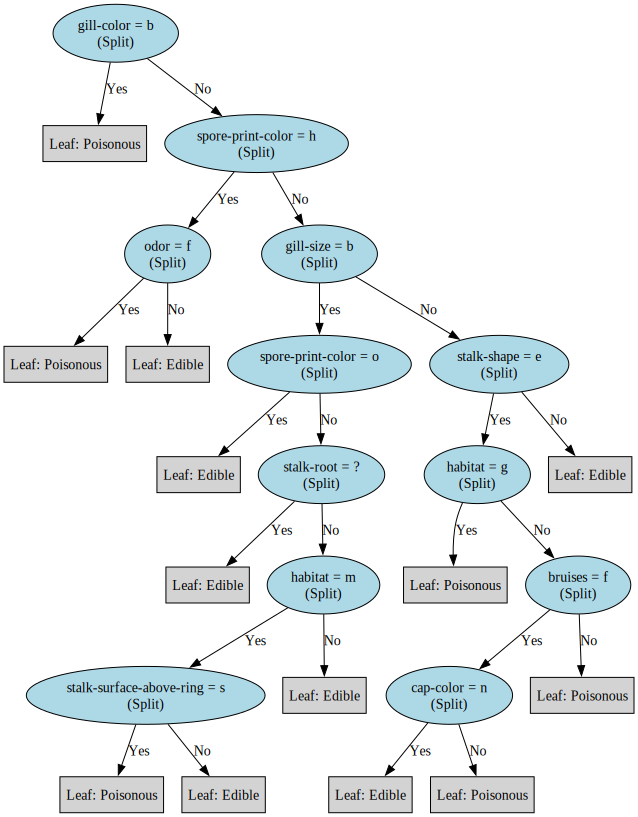

Visualization saved as: C:/Users/aknur/Downloads/entropy_tree_before_pruning.png

Entropy Tree After Pruning:


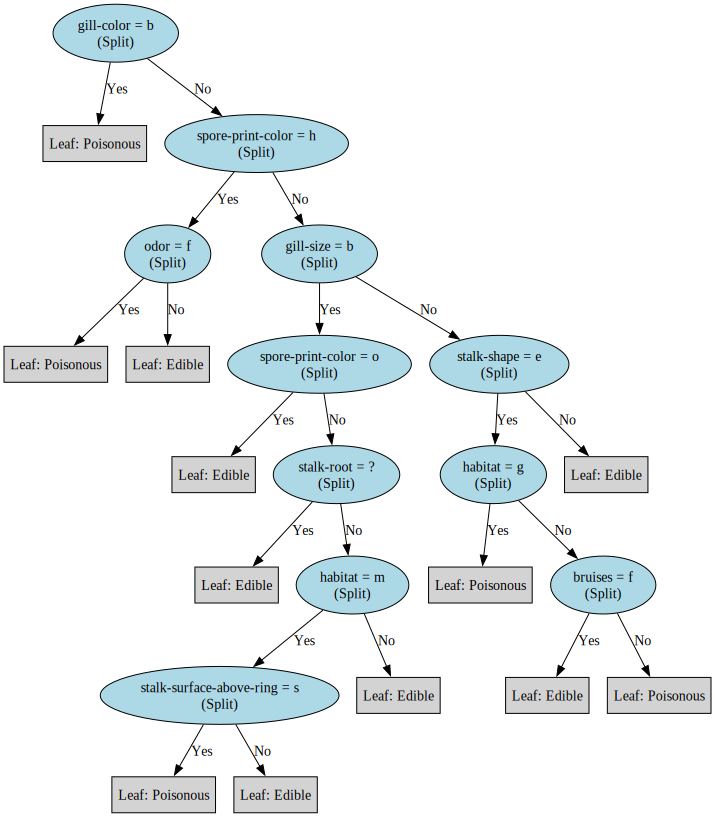

Visualization saved as: C:/Users/aknur/Downloads/entropy_tree_after_pruning.png


In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
           "gill-attachment", "gill-spacing", "gill-size", "gill-color",
           "stalk-shape", "stalk-root", "stalk-surface-above-ring",
           "stalk-surface-below-ring", "stalk-color-above-ring",
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
           "ring-type", "spore-print-color", "population", "habitat"]
df = pd.read_csv(url, names=columns)
df = df.sample(frac=1).reset_index(drop=True)

feature_names = list(df.drop(columns=['class']).columns)  

entropy_tree_before = VisualDecisionTree(criterion="entropy", feature_names=feature_names)
entropy_tree_before.fit(X_train_new, y_train_new)

class VisualDecisionTree(DecisionTreeWithPruning):
    def __init__(self, criterion="entropy", feature_names=None):
        super().__init__(criterion=criterion)
        self.feature_names = feature_names 

    def export_graphviz(self, node=None, graph=None, parent=None, edge_label=""):

        if graph is None:
            graph = Digraph()
            graph.attr(size="12,12")  

        if node is None:
            node = self.root  

        node_id = str(id(node))

        if node.is_leaf():
            label = f"Leaf: {'Poisonous' if node.value == 1 else 'Edible'}"
            graph.node(node_id, label, shape="box", style="filled", fillcolor="lightgray")
        else:
            feature_name = self.feature_names[node.feature] if self.feature_names else f"Feature {node.feature}"

            if isinstance(node.threshold, (int, float)):
                label = f"{feature_name} ≤ {node.threshold:.2f}\n(Split)"
            else:
                label = f"{feature_name} = {node.threshold}\n(Split)"

            graph.node(node_id, label, shape="ellipse", style="filled", fillcolor="lightblue")

        if parent is not None:
            graph.edge(parent, node_id, label=edge_label)

        if node.left:
            self.export_graphviz(node.left, graph, node_id, "Yes")
        if node.right:
            self.export_graphviz(node.right, graph, node_id, "No")

        return graph


def display_tree(tree, title="Decision Tree Visualization", filename="decision_tree"):
    print(f"\n{title}:")
    graph = tree.export_graphviz()

    png_path = f"C:/Users/aknur/Downloads/{filename}"
    graph.render(png_path, format="png", cleanup=True) 

    display(graph)

    print(f"Visualization saved as: {png_path}.png")

display_tree(entropy_tree_before, title="Entropy Tree Before Pruning", filename="entropy_tree_before_pruning")
entropy_tree_before.prune(X_val, y_val)
display_tree(entropy_tree_before, title="Entropy Tree After Pruning", filename="entropy_tree_after_pruning")

    

